# Setup

Using [geemap docker](https://hub.docker.com/r/bkavlak/geemap)

```bash
# pull
docker pull bkavlak/geemap:latest

# check
docker image ls

# run
docker run -it --name geemap -p 8888:8888 -p 6006:6006 -v '/Users/bbest/My Drive/projects/offhab/data/_geemap':/geemap/data bkavlak/geemap:latest bash
```

## Shutdown VM

```bash
docker stop geemap
```

## Restart VM

```bash
docker start geemap
docker exec -it geemap bash

# inside VM
jupyter notebook --ip=0.0.0.0 --port=8888 --allow-root
```
visit displayed URL, eg http://127.0.0.1:8888/?token=4e18b4332bbf0a44267f18e111687c141dc1f15ec191236e

In [ ]:
visit

# Prep

TODO: get execution time per cell:
* nbextensions: [execute\_time](https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tree/master/src/jupyter_contrib_nbextensions/nbextensions/execute_time)
* [Installing jupyter\_contrib\_nbextensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html)
* [jupyter\_nbextensions\_configurator](https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator)

In [140]:
!pip install jupyter_contrib_nbextensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 18.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 26.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 kB 28.8 MB/s eta 0:00:00
  Created wheel for jupyter_contrib_nbextensions: filename=jupyter_contrib_nbextensions-0.7.0-py2.py3-none-any.whl size=23428784 sha256=3587e4cd918f57d51ae1785f1155270683b717944556ef703967ef3dfa3c07a8
  Stored in directory: /root/.cache/pip/wheels/23/ec/b4/0c45261d7b7c9da78d6cde312a3be8d3501b9516963c0692c4
  Created wheel for jupyter_contrib_core: filename=jupyter_contrib_core-0.4.2-py2.py3-none-any.whl size=17485 sha256=d58f372d6ca6250bb5b0e055740f59657a84ead6f4a5e34ae24d7c42196a8c0d
  Stored in directory: /root/.cache/pip/wheel

In [142]:
!pip install jupyter_nbextensions_configurator

In [139]:
!pip --version

pip 22.3.1 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)


In [141]:
!python3 -m pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1


# Initialize

In [7]:
import ee

ee.Initialize()

In [134]:
import geemap
import pandas as pd
import os
import time

# get image of zones
im_zones_v1 = ee.Image('projects/ee-offhab/assets/im_zones_v1')

# get image of zones, web-optimized version
im_zones_web = ee.Image("projects/ee-offhab/assets/lyrs_aphia_web/oh_zones_v1_web")
im_mask_web = im_zones_web.gt(0)

# get imagecollection of taxa layers, web-optimized COGs
ic_aphia_web_path = 'projects/ee-offhab/assets/lyrs_aphia_web'
ic_aphia_web = ee.ImageCollection(ic_aphia_web_path)

# get image_ids
ic_aphia_web_ids = ic_aphia_web.aggregate_array("system:id").getInfo()

# get featurecollection of study area, eg to clip output
f_study_v1 = ee.FeatureCollection('projects/ee-offhab/assets/oh_study_v1')

In [24]:
# use this scale number when sampling
web_scale = ic_aphia_web.first().projection().nominalScale().getInfo();
print('web_scale in meters:', web_scale);

web_scale in meters 611.49622628141


# Calculate Spp Abundance

In [52]:
im_aphia_sa = ic_aphia_web.sum()

In [137]:
im_aphia_sa = im_aphia_sa.updateMask(im_mask_web).toFloat()
task = ee.batch.Export.image.toCloudStorage(
    im_aphia_sa,
    description    = 'gee_sa_web', 
    bucket         = 'offhab_lyrs', 
    scale          = web_scale, 
    crs            = 'EPSG:3857',
    region         = im_mask_web.geometry(),
    maxPixels      = 1e13,
    shardSize      = 512,
    skipEmptyTiles = True,
    formatOptions  = {
        'cloudOptimized': True})
task.start() # 6:13pm

# Calculate Species Richness

In [123]:
def image_to_presence(im, gt_threshold=0):
    return(im.gt(gt_threshold))

ic_aphia_sp = ic_aphia_web.map(image_to_presence).sum().updateMask(im_mask_web).toFloat()
# [composites have no projection](https://developers.google.com/earth-engine/guides/ic_reducing#composites-have-no-projection)

In [129]:
im_aphia_web_presence_export = im_aphia_web_presence.updateMask(im_mask_web).toFloat()

In [130]:
task = ee.batch.Export.image.toCloudStorage(
    ic_aphia_sp, 
    description = 'gee_sp_web', 
    bucket         = 'offhab_lyrs', 
    scale          = web_scale, 
    crs            = 'EPSG:3857',
    region         = im_mask_web.geometry(),
    maxPixels      = 1e13,
    shardSize      = 512,
    skipEmptyTiles = True,
    formatOptions  = {
        'cloudOptimized': True})
task.start() # 6:13pm

# Other

useful reference, but not used in analysis

## Map an Image

In [36]:
im_sp = ee.Image(im_sp_ids[0])

### Static Map

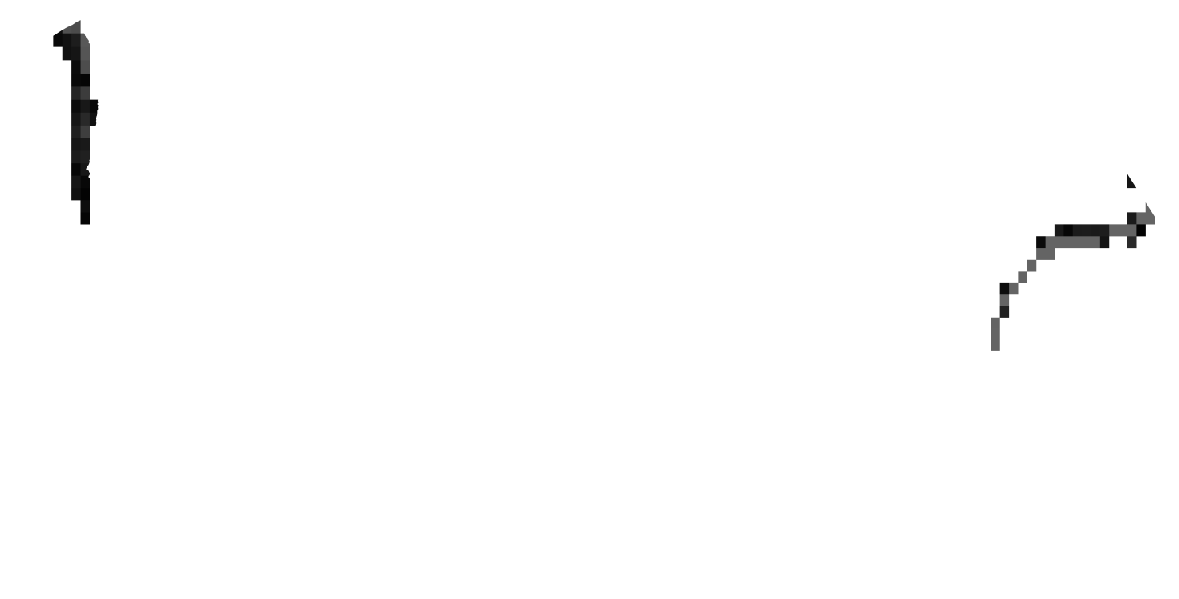

In [37]:
# static map
url = im_sp.getThumbUrl({
    'scale': web_scale*10, # 'dimensions': [800,800],
    'format': 'png'})
# print(url)
from IPython.display import Image
Image(url=url, embed=True, format='png')

## Interactive Map

In [91]:
import geemap

Map = geemap.Map(center=(45, -104), zoom=4)
Map

Map(center=[45, -104], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [89]:
pal_viridis = ['fde725', '5ec962', '21918c', '3b528b', '440154'] # viridis
vizparams_0to100 = {'min': 0, 'max': 100, 'palette': pal_viridis};

Map.addLayer(im_sp, vizparams_0to100, os.path.basename(im_sp_ids[0]), True, 0.5)

In [92]:
vizparams_sa = {'min': 35, 'max': 529766, 'palette': pal_viridis}
Map.addLayer(im_aphia_sa, vizparams_sa, 'sa', True, 0.5)

In [73]:
web_scale * 100

61149.622628141005

In [103]:
geo_us48 = ee.Geometry.Polygon([[
  [-130, 23],
  [-64, 23],
  [-64, 49],
  [-130, 49],
  [-130, 23]
]])

# A small region within the image.
bbox_us48 = ee.Geometry.BBox(-130, 23, -64, 49)

# Calculate image min/max

This method is SLOW! Since it recalculates original. Better to export to TIF and get range of values in R.

In [85]:
im_aphia_sa_minmax = im_aphia_sa.reduceRegion(
  reducer    = ee.Reducer.minMax(),
  geometry   = geo_us48, #'geometry': im_aphia_sa.geometry(),
  bestEffort = True,
  scale      = 61150,
  maxPixels  = 1e13).getInfo()
print(im_aphia_sa_minmax) # {'b1_max': 529766, 'b1_min': 35}

In [86]:
print(im_aphia_sa_minmax) # {'b1_max': 529766, 'b1_min': 35}

{'b1_max': 529766, 'b1_min': 35}


# Export

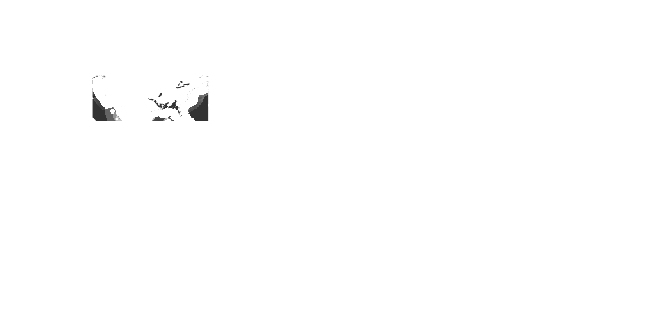

In [56]:
# static map
url = im_aphia_sa.getThumbUrl({
    'scale': web_scale*100, # 'dimensions': [800,800],
    'format': 'png'})
# print(url)
from IPython.display import Image
Image(url=url, embed=True, format='png')

In [ ]:
# Export a cloud-optimized GeoTIFF.
Export.image.toDrive({
  image: landsat,
  description: 'imageToCOGeoTiffExample',
  crs: projection.crs,
  crsTransform: projection.transform,
  region: geometry,
  fileFormat: 'GeoTIFF',
  formatOptions: {
    cloudOptimized: true
  }
});

In [107]:
geemap.ee_export_image_to_drive(
    im_aphia_sa_dbl, description='geemap-grdrive_species-abundance.', folder='ee_exports', scale=web_scale)

In [115]:
# test web presence1
im_aphia_web_presence1 = image_to_presence(ic_aphia_web.first())
vizparams_0to1 = {'min': 0, 'max': 1, 'palette': pal_viridis}
Map.addLayer(im_aphia_web_presence1, vizparams_0to1, 'presence1', True, 0.5)

In [131]:
im_aphia_sp_minmax = im_aphia_web_presence_mask_dbl.reduceRegion(
  reducer    = ee.Reducer.minMax(),
  geometry   = im_mask_web.geometry(), #'geometry': im_aphia_sa.geometry(),
  bestEffort = True,
  scale      = web_scale,
  maxPixels  = 1e13).getInfo()
print(im_aphia_sp_minmax) # 4:30 pm


KeyboardInterrupt



In [102]:
geemap.ee_export_image(
    im_aphia_sa_dbl, 
    filename      = '/Users/bbest/Downloads/geemap_species-abundance.tif', 
    scale         = web_scale,
    crs           = 'EPSG:3857',
    region        = geom_us48,
    file_per_band = False)
# 799508592 bytes: Total request size
#  50331648 bytes: must be less than or equal to .

Generating URL ...
An error occurred while downloading.
Total request size (799508592 bytes) must be less than or equal to 50331648 bytes.


In [104]:
im_aphia_sa_dbl.bandNames()

In [ ]:
Map.addLayer(im_sp, sp_viz_params, os.path.basename(im_sp_ids[0]), True, 0.5)

# Zonal stats per spp with `for` loop

In [95]:
dir_csv = '/geemap/data'

t0 = time.time()
# iterate over images
for i in range(0,20):  # i=1 
    im_sp_id = im_sp_ids[i]
    im_sp = ee.Image(im_sp_id)

    lyr_key = os.path.basename(im_sp_id)
    #print(lyr_key) # am_1006979

    means_csv = f'{dir_csv}/{lyr_key}.csv'
    print(f'{i}: {means_csv}')

    im_sp_z = im_sp.addBands(im_zones_v1)
    #print(img_z.bandNames().getInfo()) # ['b1', 'b1_1'] # TODO: rename band

    # Grouped a mean reducer: change of nightlights by land cover category.
    means = im_sp_z.reduceRegion(
       reducer = ee.Reducer.mean().group(
           groupField = 1,
           groupName  = 'zone_id'),
       geometry  = im_zones_v1.geometry(),
       scale     = 481,
       maxPixels = 2.2e8).getInfo()['groups']
    # {'groups': [{'zone_id': 1}, {'mean': 61, 'zone_id': 2}, {'mean': 40.145293103263604, 'zone_id': 3}, {'mean': 97.8158977279919, 'zone_id': 4}, {'zone_id': 5}, {'zone_id': 6}, {'zone_id': 7}, {'zone_id': 8}, {'zone_id': 9}, {'zone_id': 10}, {'zone_id': 11}]}

    df = pd.DataFrame.from_records(means)
    # print(df)
    df.to_csv(means_csv, index = False)
    
sec_elapsed = time.time() - t0
print(f'time elapsed: {sec_elapsed:.2f} sec')
#  0:5: 5.24 sec 
# 0:20: 41.17 sec


0: /geemap/data/am_100599.csv
1: /geemap/data/am_1006979.csv
2: /geemap/data/am_1007713.csv
3: /geemap/data/am_100832.csv
4: /geemap/data/am_100833.csv
5: /geemap/data/am_100834.csv
6: /geemap/data/am_100838.csv
7: /geemap/data/am_100839.csv
8: /geemap/data/am_100841.csv
9: /geemap/data/am_100842.csv
10: /geemap/data/am_100854.csv
11: /geemap/data/am_100862.csv
12: /geemap/data/am_100872.csv
13: /geemap/data/am_100930.csv
14: /geemap/data/am_100933.csv
15: /geemap/data/am_100954.csv
16: /geemap/data/am_100966.csv
17: /geemap/data/am_100982.csv
18: /geemap/data/am_101021.csv
19: /geemap/data/am_101036.csv
time elapsed: 41.17 sec


# Zonal stats per spp with `toBands()` & `FeatureCollection`

In [97]:
t0 = time.time()
fc_zones = ee.FeatureCollection('projects/ee-offhab/assets/fc_zones')
fc_zones_v1 = fc_zones.filter(ee.Filter.eq('zn_vrsn', 1))

means_csv = f'{dir_csv}/sp_z_0to20.csv'
ic_lyrs = ee.ImageCollection([ee.Image(x) for x in im_sp_ids[0:20]])
im_lyrs = ic_lyrs.toBands()
#print(im_lyrs.bandNames().getInfo())
# ['am_100599_b1', 'am_1006979_b1', 'am_1007713_b1', 'am_100832_b1', 'am_100833_b1']

# print(ic_lyrs.aggregate_array("system:id").getInfo())

r = im_lyrs.reduceRegions(
    collection = fc_zones_v1.select('zone_ky'),
    reducer    = ee.Reducer.mean(),
    scale      = 481,
    crs        = 'EPSG:4326').select(
        propertySelectors = '.*', # ['zone_ky', 'am_100599_b1'],
        retainGeometry = False).getInfo()
r_df = pd.DataFrame.from_records([x['properties'] for x in r['features']])
#print(r_df)
r_df.to_csv(means_csv, index = False)

sec_elapsed = time.time() - t0
print(f'time elapsed: {sec_elapsed:.2f} sec')
#  0:5: 125.65 sec
# 0:20: 176.48 sec

time elapsed: 176.48 sec


## Extra Methods

In [38]:
url = r.getDownloadURL(
  filetype  = 'CSV',
  selectors = ['zone_ky', 'am_100599_b1'],
  filename  = 'lyr_zones_means.csv')
print(url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/tables/645dd94a984094529e1d14d214d7b383-47912123b32e3968f04a0436016324b4:getFeatures


In [ ]:
task = ee.batch.Export.table.toDrive(
  collection  = r_f,
  description =  'r_f_2cols',
  fileFormat  =  'CSV',
  selectors   = ['zone_ky', 'am_100599_b1'])
task.start()

In [ ]:
# ImageCollection.map()
def get_sp_zonal_stats(im_sp):
    #lyr_key = im_sp.get('lyr_key').getInfo()
    #means_csv = f'{dir_csv}/{lyr_key}.csv'
    #print(f'{means_csv}')
    im_sp_z = im_sp.addBands(ee.Image('projects/ee-offhab/assets/im_zones_v1'))
    means = im_sp_z.reduceRegion(
       reducer = ee.Reducer.mean().group(
           groupField = 1,
           groupName  = 'zone_id'),
       #geometry  = im_sp.geometry(),
       scale     = 481,
       maxPixels = 2.2e8)
    return means

reduced = ic_lyrs.map(get_sp_zonal_stats).flatten()
#.getInfo()['groups']
# EEException: Collection.map: A mapped algorithm must return a Feature or Image.